<a href="https://colab.research.google.com/github/alexeiplatzer/unitree-go2-mjx-rl/blob/main/notebooks/madrona_quadruped_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install additional missing packages
!sudo apt install -y libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev
#!sudo apt install -y nvidia-cuda-toolkit

# install jax with cuda enabled
!pip install -U "jax[cuda12_local]<0.6.0"

# get madrona mjx and its subpackages
!mkdir modules
!git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx
!git -C modules/madrona_mjx submodule update --init --recursive

# build madrona mjx
!mkdir modules/madrona_mjx/build
!cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8

# install madrona mjx
!pip install -e modules/madrona_mjx

# install other libraries
!pip install mujoco==3.3.2
!pip install mujoco_mjx==3.3.2

# Clones and installs our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!pip install -e unitree-go2-mjx-rl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libx11-dev is already the newest version (2:1.7.5-1ubuntu0.3).
libx11-dev set to manually installed.
The following additional packages will be installed:
  libdrm-dev libgl-dev libglx-dev libpciaccess-dev libxfixes-dev
The following NEW packages will be installed:
  libdrm-dev libgl-dev libglx-dev libpciaccess-dev libxcursor-dev
  libxfixes-dev libxi-dev libxinerama-dev libxrandr-dev mesa-common-dev
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,906 kB of archives.
After this operation, 6,893 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpciaccess-dev amd64 0.16-3 [21.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdrm-dev amd64 2.4.113-2~ubuntu0.22.04.1 [292 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:4 http://archive.ubuntu.

In [2]:
# @title Refresh the package if any necessary changes have been pushed. Important in development
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 6 (delta 4), reused 6 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 783 bytes | 391.00 KiB/s, done.
From https://github.com/alexeiplatzer/unitree-go2-mjx-rl
   a2e1194..3679f17  main       -> origin/main
Updating a2e1194..3679f17
Fast-forward
 .../environments/vision_debug_primitive.py         | 24 +++++++++++++++++++++-
 1 file changed, 23 insertions(+), 1 deletion(-)


In [1]:
# @title Imports and definitions

# On your second reading, load the compiled rendering backend to save time!
import os
# On your second reading, load the compiled rendering backend to save time!
# os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "<YOUR_PATH>/madrona_mjx/build/cache"
# Ensure that Madrona gets the chance to pre-allocate memory before Jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Temporarily limit to just one device
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
# TEMPORARILY DISABLE, THIS LOOKS LIKE IT BREAKS SHIT
# xla_flags = os.environ.get('XLA_FLAGS', '')
# xla_flags += ' --xla_gpu_triton_gemm_any=True'
# os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare directories
from etils.epath import Path
repo_path = Path("unitree-go2-mjx-rl")
# experiments_dir = Path("experiments")
# trained_policy_dir = experiments_dir / "trained_policies"
# !mkdir -p {trained_policy_dir}
# configs_dir = experiments_dir / "configs"
# !mkdir -p {configs_dir}
# rollout_configs_dir = configs_dir / "rollout_configs"
# !mkdir -p {rollout_configs_dir}
# animations_dir = experiments_dir / "rendered_rollouts"
# !mkdir -p {animations_dir}

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Utility
from functools import partial

# Visualisation
import mediapy as media
import matplotlib.pyplot as plt

# Simulation
import mujoco
from mujoco import mjx

# Math
import jax
import jax.numpy as jnp

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [2]:
# Configurations

# Robot
from quadruped_mjx_rl.robots import predefined_robot_configs
robot = "unitree_go2"
robot_config = predefined_robot_configs[robot]()

# Model
from quadruped_mjx_rl import models
model_config = models.TeacherStudentVisionConfig(
    modules=models.TeacherStudentVisionConfig.ModulesConfig(
        policy=[256, 256],
        value=[256, 256],
        encoder_convolutional=[32, 32],
        encoder_dense=[256, 256],
        adapter_convolutional=[32, 32],
        adapter_dense=[256, 256],
    ),
    latent_size=128,
)

# Environment
# from quadruped_mjx_rl import environments
# env_config = environments.QuadrupedVisionEnvConfig()
# env_config.use_vision = True

from quadruped_mjx_rl.environments.vision_debug import VisionDebugEnv
from quadruped_mjx_rl.environments import JoystickBaseEnvConfig
env_config = JoystickBaseEnvConfig()

# Training
from quadruped_mjx_rl import training
num_envs = 32
training_config = training.TrainingWithVisionConfig(
    num_envs=num_envs,
    num_eval_envs=num_envs,
)

# In-training rendering
from quadruped_mjx_rl import robotic_vision
vision_config = robotic_vision.VisionConfig(
    render_batch_size=num_envs,
    enabled_cameras=[0, 1, 2],
    enabled_geom_groups=[0, 1, 2],
    render_width=64
)

# File path to the initial scene
init_scene_path = repo_path / "resources" / robot_config.robot_name / "scene_mjx_vision.xml"

In [3]:
from quadruped_mjx_rl.environments import get_env_factory
# env_factory, uses_vision = get_env_factory(
#     env_config=env_config,
#     robot_config=robot_config,
#     init_scene_path=init_scene_path,
# )
# env = env_factory(vision_config=vision_config)

env = VisionDebugEnv(env_config, robot_config, init_scene_path, vision_config)

/usr/local/lib/python3.11/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [4]:
from quadruped_mjx_rl.environments.wrappers import wrap_for_training
env = wrap_for_training(
    env=env,
    vision=True,
    num_vision_envs=num_envs,
)
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [5]:
state = jit_reset(jax.random.split(jax.random.PRNGKey(0), num_envs))
rgb_tensor = state.obs["pixels/rgb_tensor"]
depth_tensor = state.obs["pixels/depth_tensor"]
rgb_tensor.shape

(32, 3, 64, 64, 4)

In [6]:
def tile(img, d):
    assert img.shape[0] == d*d
    img = img.reshape((d,d)+img.shape[1:])
    return np.concat(np.concat(img, axis=2), axis=2)

image = tile(rgb_tensor[:16], 4)
image.shape

(3, 256, 256, 4)

""

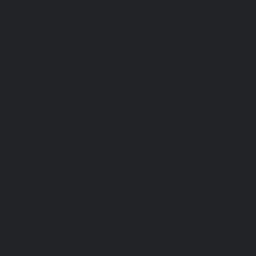

In [9]:
media.show_image(image[2], width=512)